In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT / "src"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from cycle_tda.io import load_csv
from cycle_tda.selection import select_embedding_params
from cycle_tda.rolling import rolling_ph
from cycle_tda.metrics import summarize_series, usability_score
from cycle_tda.config import WINDOW_MONTHS, STRIDE


In [3]:
df = load_csv(
    PROJECT_ROOT / "data/raw/XAU_Monthly.csv",
    date_col="Date",
    value_col="Close",
)

series = np.log(df.set_index("Date")["Close"]).dropna()

print("Rows:", len(series))
print("Range:", series.index.min(), "→", series.index.max())


Rows: 1396
Range: 1793-03-31 00:00:00 → 2025-12-31 00:00:00


In [4]:
tau, m, info = select_embedding_params(
    series,
    max_tau=WINDOW_MONTHS // 4,
    tau_cap=WINDOW_MONTHS // 4
)

print(f"Embedding params: m={m}, tau={tau}")


Embedding params: m=4, tau=3


In [5]:
df_ph_full = rolling_ph(
    series=series,
    window=WINDOW_MONTHS,
    stride=STRIDE,
    m=m,
    tau=tau,
)


In [6]:
df_ph_71 = rolling_ph(
    series=series[series.index >= "1971-01-01"],
    window=WINDOW_MONTHS,
    stride=STRIDE,
    m=m,
    tau=tau,
)


In [7]:
df_ph_71 = rolling_ph(
    series=series[series.index >= "1971-01-01"],
    window=WINDOW_MONTHS,
    stride=STRIDE,
    m=m,
    tau=tau,
)


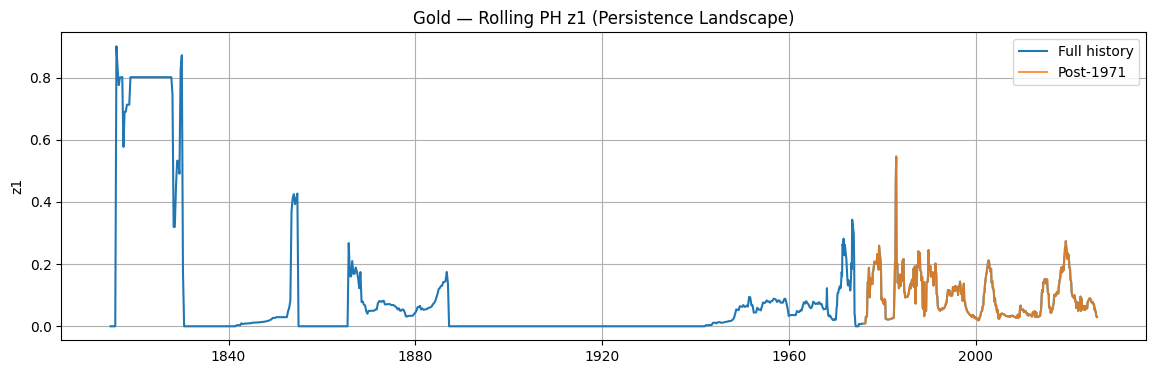

In [8]:
plt.figure(figsize=(14,4))
plt.plot(df_ph_full.index, df_ph_full["z1"], label="Full history")
plt.plot(df_ph_71.index, df_ph_71["z1"], label="Post-1971", alpha=0.8)
plt.title("Gold — Rolling PH z1 (Persistence Landscape)")
plt.ylabel("z1")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
rows = []

for label, df_ in [
    ("Full", df_ph_full),
    ("Post-1971", df_ph_71),
]:
    stats = summarize_series(df_["z1"].values)
    rows.append({
        "era": label,
        **stats,
        "usability": usability_score(stats["p90"], stats["cv"]),
    })

pd.DataFrame(rows)


,era,mean,p90,std,cv,active_rate,usability
0,Full,0.111546,0.208972,0.165784,1.486240,0.100000,0.140605
1,Post-1971,0.097517,0.189611,0.065877,0.675538,0.101498,0.280681
